# GU003 – StarDist single-patch nucleus segmentation

# Step 1: Mount Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Step 2: Define WSI path


In [3]:
wsi_path = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif"



# Step 3: Inspect TIFF structure (lazy)



In [4]:
import tifffile as tiff
with tiff.TiffFile(wsi_path) as tif:
    print(len(tif.pages), tif.pages[0].shape)


9 (30127, 47808, 3)


# Step 3.1: Open WSI and inspect slide properties


In [5]:
!pip install tifffile


# Step 3.2: Inspect TIFF structure (without loading full image)


In [5]:
import tifffile as tiff

with tiff.TiffFile(wsi_path) as tif:
    print("Number of pages:", len(tif.pages))
    page = tif.pages[0]
    print("Page shape:", page.shape)
    print("Page dtype:", page.dtype)


Number of pages: 9
Page shape: (30127, 47808, 3)
Page dtype: uint8


Step 4.1: Choose one fixed 256×256 patch coordinate (level-0)


In [6]:
# Patch parameters (level-0 coordinates)
PATCH_SIZE = 256
x0, y0 = 10000, 15000   # 随便先定一个，后面可以系统化采样


Step 4.2a:Install imagecodecs to enable JPEG-compressed TIFF decoding


In [7]:
!pip install imagecodecs


Step 4.2.b: Re-define WSI path to ensure variable exists in current runtime


In [8]:
# Re-define critical input paths (do not rely on previous cells)
wsi_path = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif"

import os
assert os.path.exists(wsi_path), f"WSI not found: {wsi_path}"


Step 4.2.c: Re-define patch coordinates to ensure variables exist


In [9]:
# Re-define patch coordinates (do not rely on previous cells)
PATCH_SIZE = 256
x0, y0 = 10000, 15000


Step 4.2.d: Lazily extract one 256×256 patch from level-0 TIFF


In [10]:
import tifffile as tiff
import numpy as np

with tiff.TiffFile(wsi_path) as tif:
    page0 = tif.pages[0]  # level-0
    patch = page0.asarray()[
        y0:y0 + PATCH_SIZE,
        x0:x0 + PATCH_SIZE
    ]

patch.shape


(256, 256, 3)

Step 5.1: Visualize the extracted patch to verify tissue and nuclei content


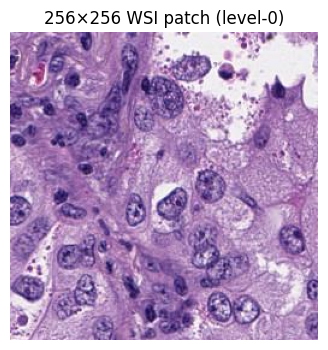

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.imshow(patch)
plt.axis("off")
plt.title("256×256 WSI patch (level-0)")
plt.show()


Step 5.2: Normalize patch intensity for StarDist inference


In [12]:
# Convert to float32 and normalize to [0, 1]
patch_norm = patch.astype("float32") / 255.0

patch_norm.shape, patch_norm.dtype, patch_norm.min(), patch_norm.max()


((256, 256, 3), dtype('float32'), np.float32(0.003921569), np.float32(1.0))

Step 5.3: Visualize normalized patch (sanity check)


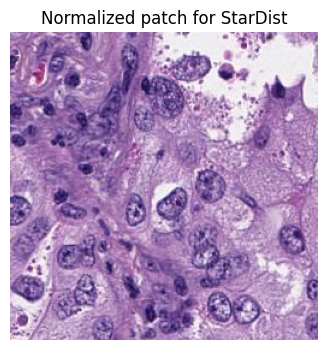

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(patch_norm)
plt.axis("off")
plt.title("Normalized patch for StarDist")
plt.show()


Step 6: Run StarDist nucleus instance segmentation on the patch


Step 6.1: Install StarDist and load pretrained nucleus model


In [12]:
# Install StarDist and dependencies
!pip install stardist csbdeep


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.1 MB/s eta 0:00:00


Step 6.2: Load pretrained StarDist 2D model for nuclei


In [13]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

# Load pretrained H&E nucleus model
model = StarDist2D.from_pretrained('2D_versatile_he')


Found model '2D_versatile_he' for 'StarDist2D'.
5294730/5294730 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


Step 6.3.a: Re-define WSI path and patch to ensure variables exist in current runtime



In [14]:
# Re-define WSI path and extracted patch (do not rely on previous cells)
import os
import tifffile as tiff
import numpy as np

# --- Critical input path ---
wsi_path = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif"
assert os.path.exists(wsi_path), f"WSI not found: {wsi_path}"

# --- Patch parameters (level-0) ---
PATCH_SIZE = 256
x0, y0 = 10000, 15000

# --- Extract patch ---
with tiff.TiffFile(wsi_path) as tif:
    page0 = tif.pages[0]  # level-0
    patch = page0.asarray()[
        y0:y0 + PATCH_SIZE,
        x0:x0 + PATCH_SIZE
    ]

assert patch.shape == (256, 256, 3), f"Unexpected patch shape: {patch.shape}"


Step 6.3.b: Re-define normalized patch to ensure variable exists in current runtime


In [15]:
# Re-define normalized patch (do not rely on previous cells)
import numpy as np

patch_norm = patch.astype("float32") / 255.0

assert patch_norm.shape == (256, 256, 3), f"Unexpected patch_norm shape: {patch_norm.shape}"


Step 6.3: Run StarDist nucleus instance segmentation on the patch


In [16]:
# Normalize again using csbdeep (StarDist-recommended)
patch_sd = normalize(patch_norm, 1, 99.8, axis=(0, 1))

# Run StarDist prediction
labels, details = model.predict_instances(patch_sd)

labels.shape, labels.max()


((256, 256), np.int32(32))

Step 6.4: Visualize StarDist instance segmentation by overlaying instance masks on the input patch (Python only, no QuPath)


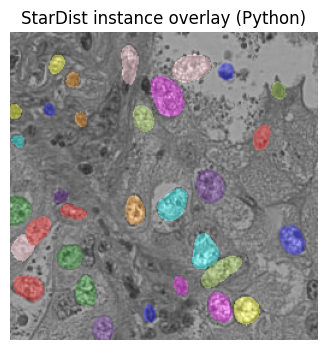

In [17]:
# Overlay StarDist instance masks on the original patch
import matplotlib.pyplot as plt
from skimage.color import label2rgb

overlay = label2rgb(
    labels,
    image=patch,
    bg_label=0,
    alpha=0.35
)

plt.figure(figsize=(4, 4))
plt.imshow(overlay)
plt.axis("off")
plt.title("StarDist instance overlay (Python)")
plt.show()


Step 6.5: Convert StarDist instance segmentation results into GeoJSON polygons for downstream spatial analysis


In [18]:
# Convert instance labels to GeoJSON polygons
import json
import numpy as np
from skimage.measure import regionprops, find_contours

geojson_features = []

for region in regionprops(labels):
    instance_id = int(region.label)

    # binary mask for one instance
    mask = (labels == instance_id).astype(np.uint8)

    contours = find_contours(mask, level=0.5)
    if len(contours) == 0:
        continue

    # use largest contour
    contour = max(contours, key=len)

    # convert (row, col) -> (x, y)
    coordinates = [[float(c[1]), float(c[0])] for c in contour]

    feature = {
        "type": "Feature",
        "properties": {
            "instance_id": instance_id,
            "area_px": int(region.area),
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [coordinates],
        },
    }

    geojson_features.append(feature)

geojson = {
    "type": "FeatureCollection",
    "features": geojson_features,
}

len(geojson_features)


32

Step 6.5.b: Save instance-level GeoJSON to disk for sharing and downstream use


In [19]:
geojson_path = "stardist_patch_instances.geojson"

with open(geojson_path, "w") as f:
    json.dump(geojson, f, indent=2)

geojson_path


'stardist_patch_instances.geojson'

Step 6.5.c: Save instance-level GeoJSON to Google Drive for persistence and sharing


In [20]:
import os
import json

# ---- Google Drive output path ----
out_dir = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/outputs"
os.makedirs(out_dir, exist_ok=True)

geojson_path = os.path.join(out_dir, "stardist_patch_instances.geojson")

with open(geojson_path, "w") as f:
    json.dump(geojson, f, indent=2)

geojson_path


'/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/outputs/stardist_patch_instances.geojson'

Step 7: Extend instance-level GeoJSON by adding centroid for each nucleus


In [21]:
import numpy as np

# geojson 已在 Step 6 构建完成
# 每个 feature 里已有 geometry + properties（area_px / confidence 等）

for feature in geojson["features"]:
    coords = feature["geometry"]["coordinates"][0]  # Polygon outer ring

    # coords: [[x1, y1], [x2, y2], ...]
    xs = [p[0] for p in coords]
    ys = [p[1] for p in coords]

    cx = float(np.mean(xs))
    cy = float(np.mean(ys))

    feature["properties"]["centroid"] = {
        "x": cx,
        "y": cy
    }

len(geojson["features"])


32

Step 7.1: Save centroid-augmented GeoJSON to Google Drive


In [22]:
import os, json

out_dir = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/outputs"
os.makedirs(out_dir, exist_ok=True)

geojson_path = os.path.join(out_dir, "stardist_patch_instances_with_centroid.geojson")

with open(geojson_path, "w") as f:
    json.dump(geojson, f, indent=2)

geojson_path


'/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/outputs/stardist_patch_instances_with_centroid.geojson'

Step 8: Sanity-check alignment by overlaying centroids and polygons on the patch


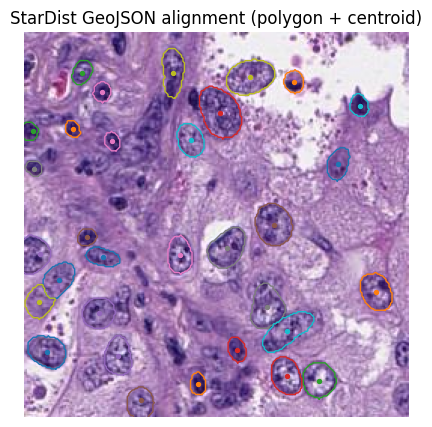

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(patch)
plt.axis("off")

# overlay polygons + centroids
for feature in geojson["features"]:
    coords = feature["geometry"]["coordinates"][0]
    xs = [p[0] for p in coords]
    ys = [p[1] for p in coords]

    plt.plot(xs, ys, linewidth=1)  # polygon outline

    c = feature["properties"]["centroid"]
    plt.scatter(c["x"], c["y"], s=8)

plt.title("StarDist GeoJSON alignment (polygon + centroid)")
plt.show()
